In [1]:
# Library Imports 
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
importlib.reload(mf)
from collections import defaultdict

In [2]:
data_path = "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/"
figure_save_path="/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/Thesis Figures and Diagrams/Figures/MyResults"
data_file ="data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-07-47_freq_195.11847_rng_36.6852_gain_30_fld_0.0.csv"

## Functions ## 

In [3]:
def read_B_field(file_name):
    match = re.search(r'fld_([0-9.]+)', file_name)
    if match: 
        
        b_field = float(match.group(1).strip("."))
        return b_field
    else: 
        print("Error: field value not found in filename.")

## Single Spectrum ## 

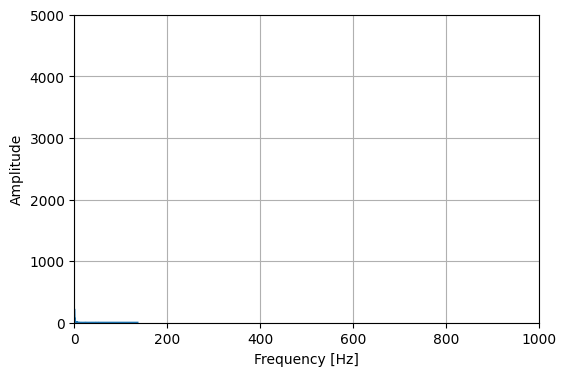

<Figure size 640x480 with 0 Axes>

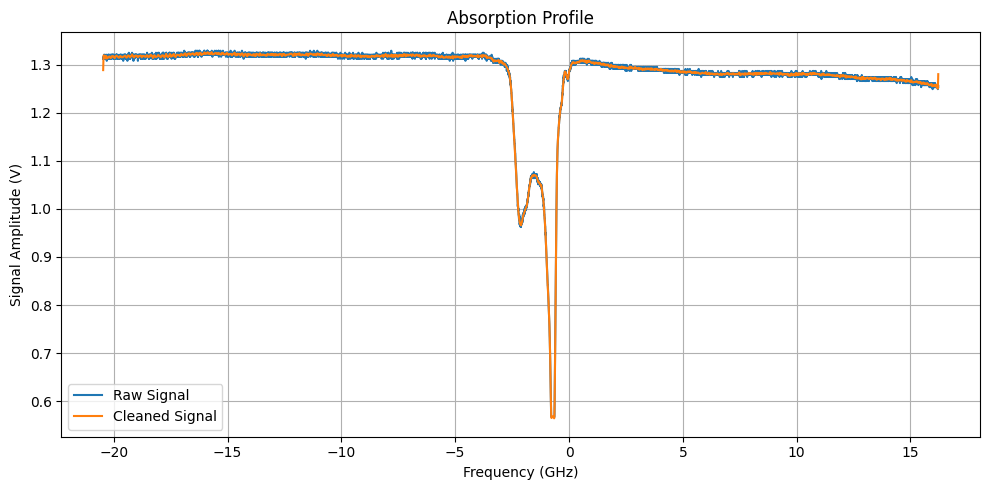

In [4]:

# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9
## Low Pass Band Filter ## 20 Hz. 
cleaned = mf.low_pass_band_filter_fft(20,freq_axis_GHz,voltage,plot_check=True)

# Plot absorption profile
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(freq_axis_GHz, voltage, label='Raw Signal')
ax.plot(freq_axis_GHz, cleaned, label='Cleaned Signal')
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("Signal Amplitude (V)")
ax.set_title("Absorption Profile")
ax.grid(True)
ax.legend()
fig.tight_layout()
plt.show()

## 2D Colour Map ## 

In [63]:
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    #voltage = mf.low_pass_band_filter_fft(20,freq_axis_GHz,voltage,plot_check=False)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]


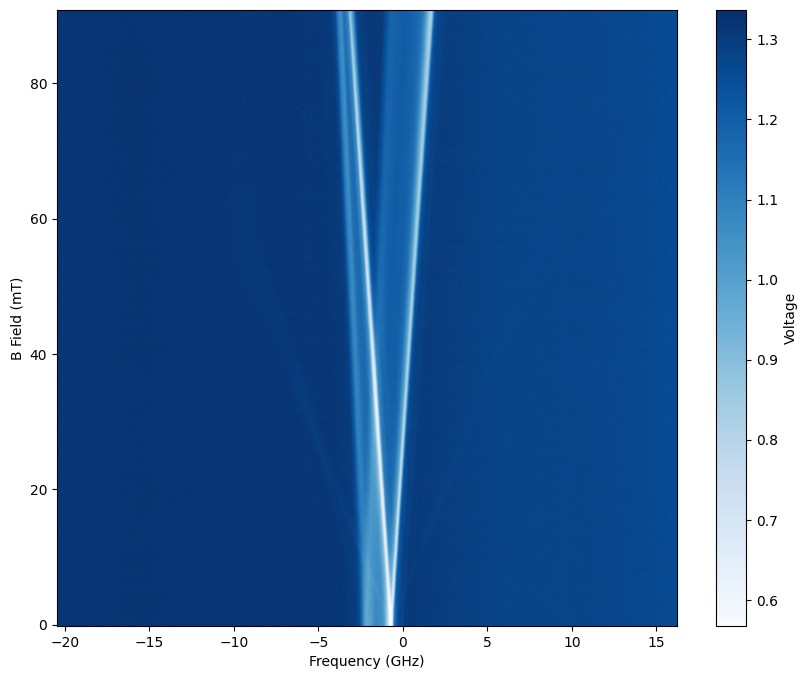

In [64]:
fig, ax = plt.subplots(figsize=(10,8))
c= ax.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
#ax.pcolormesh(fields * 1000, freq_axis_GHz, voltages.T, shading='auto', cmap='Blues')  # Alternative plot
#ax.set_xlim([-10, 10])
#ax.set_ylim([80, 90])  # Uncomment and set limits if needed
fig.colorbar(c, ax=ax, label="Voltage")
ax.set_xlabel("Frequency (GHz)")
ax.set_ylabel("B Field (mT)")
plt.show()


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data for each peak
peak_paths = {
    "A": "data_optics/peak_picking_data/2025_04_07_16_15_25_absorption_peaks_2025-03-25_peak_A.csv",
    "B": "data_optics/peak_picking_data/2025_04_07_16_38_22_absorption_peaks_2025-03-25_peak_B.csv",
    "C": "data_optics/peak_picking_data/2025_04_07_16_42_53_absorption_peaks_2025-03-25_peak_C.csv",
    "D": "data_optics/peak_picking_data/2025_04_07_16_47_17_absorption_peaks_2025-03-25_peak_D_fix.csv",
    "E": "data_optics/peak_picking_data/2025_04_07_16_53_26_absorption_peaks_2025-03-25_peak_E.csv",
    "F": "data_optics/peak_picking_data/2025_04_07_16_58_55_absorption_peaks_2025-03-25_peak_F.csv"
}

peak_data = {}
slopes = {}

# Load each peak data into a dictionary and calculate the slope and R^2
for peak, path in peak_paths.items():
    data = pd.read_csv(path)
    freq = data['Frequency (GHz)'].values
    b_field = data['B Field (mT)'].values

    # Linear fit
    fit = np.polyfit(b_field, freq, 1)  # Slope and intercept
    slope = fit[0]
    intercept = fit[1]

    # Calculate fitted values
    fitted_values = np.poly1d(fit)(b_field)

    # Calculate R^2
    ss_res = np.sum((freq - fitted_values) ** 2)
    ss_tot = np.sum((freq - np.mean(freq)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    slopes[peak] = (slope, intercept, r_squared)
    # Store the data and fit line
    peak_data[peak] = {
        "freq": freq,
        "b_field": b_field,
        "slope": slope,
        "r_squared": r_squared,
        "fit_line": fitted_values,
        "intercept": intercept
    }
    print(f"Slope of Peak {peak}: {slope:.6f} GHz/mT, R²: {r_squared:.6f}, Intercept: {intercept:.6f}")


Slope of Peak A: -0.026909 GHz/mT, R²: 0.999348, Intercept: -0.675555
Slope of Peak B: 0.026532 GHz/mT, R²: 0.999257, Intercept: -0.697532
Slope of Peak C: -0.019576 GHz/mT, R²: 0.959734, Intercept: -1.941016
Slope of Peak D: 0.017369 GHz/mT, R²: 0.993734, Intercept: -2.126620
Slope of Peak E: -0.134052 GHz/mT, R²: 0.992956, Intercept: -1.302576
Slope of Peak F: 0.162016 GHz/mT, R²: 0.999220, Intercept: -0.688081


/var/folders/zj/k61bftd91r1cdpjh8_mkq7nm0000gn/T/ipykernel_10331/630239493.py:12: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 2 Axes> than <Figure size 1000x800 with 2 Axes> which fig.colorbar is called on.
  fig.colorbar(c, ax=ax2, label="Voltage")


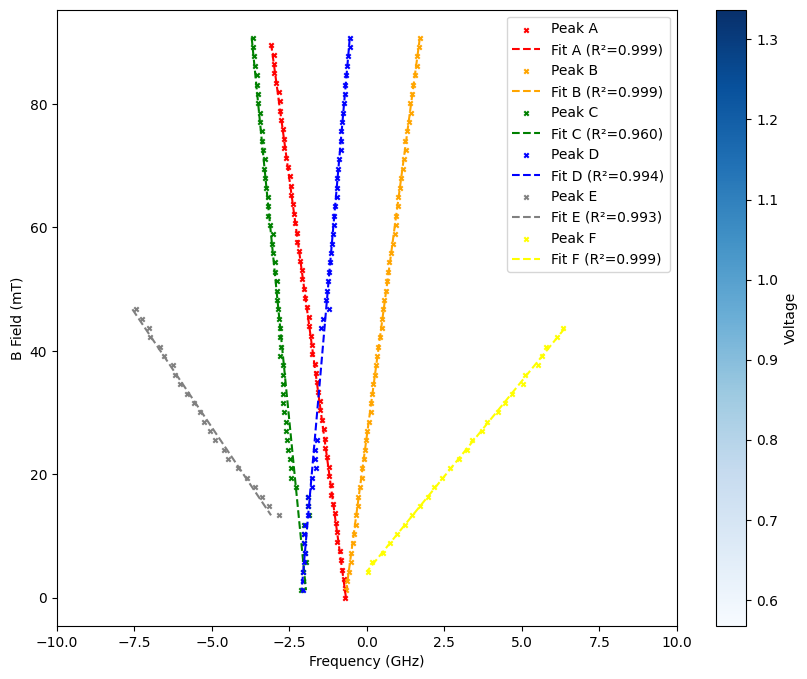

In [69]:
# Plot the data and linear fits
fig, ax2 = plt.subplots(figsize=(10, 8))
#c = ax2.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')

# Plot the scatter points and linear fits for each peak
colors = ['red', 'orange', 'green', 'blue', 'grey', 'yellow']
for i, (peak, data) in enumerate(peak_data.items()):
    ax2.scatter(data['freq'], data['b_field'], color=colors[i], marker='x', label=f"Peak {peak}", s=10)
    ax2.plot(data['fit_line'], data['b_field'], color=colors[i], linestyle='--', label=f"Fit {peak} (R²={data['r_squared']:.3f})")

# Add color bar and labels
fig.colorbar(c, ax=ax2, label="Voltage")
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel("B Field (mT)")
ax2.legend()
ax2.set_xlim([-10,10])
plt.show()

## G Tensor Calculations ## 

## Inhomogeniety ## 
